# Read mnist, try basic operations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    
C = Const()

In [3]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

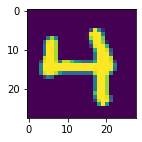

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(xtrain[np.random.randint(xtrain.shape[0]),:,:,0]);

In [5]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6


 .244 .069 .052 .040 .036 .030 .027 .025 .022 .021
 .017 .018 .017 .015 .014 .013 .012 .010 .011 .011
 .010 .009 .009 .009 .009 .007 .009 .007 .006 .006
 .008 .008 .006 .006 .006 .005 .006 .005 .007 .006
 .005 .005 .006 .005 .004 .004 .006 .006 .005 .005

Text(0, 0.5, 'Loss')

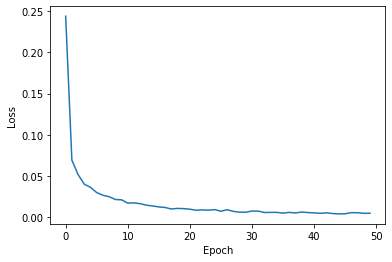

In [6]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')
        # Funny replace function strips leading zeros (looks better that way)
        

hist = model.fit(xtrain, ytrain,
                  batch_size=128,
                  epochs=50,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [7]:
score = model.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

Test loss: 0.029117557456145585
Accuracy: 0.9941
Percent error: 0.59%


# Minimalistic training with overfitting

[[ 1  3  5  7  2  0 13 15 17  4]
 [21  6 16 10  9 11 18 29 31 19]
 [34  8 25 12 20 35 32 38 41 22]
 [37 14 28 27 26 47 36 42 46 33]
 [51 23 76 30 53 65 39 52 55 43]]


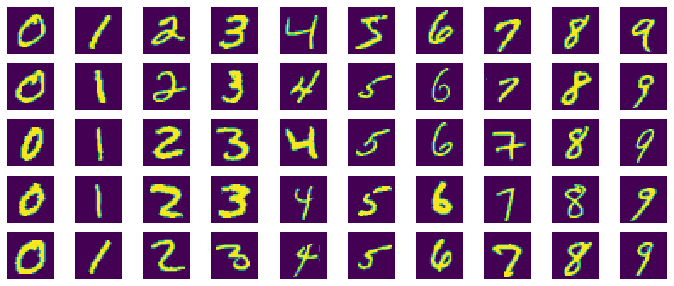

In [8]:
# Pick a few complete sets of digits

nrows = 5
hist = [0]*10
indices = np.zeros((nrows, 10), dtype=int)
plt.figure(figsize=(12,5))
i = 0
while min(hist) < nrows:
    label = np.argmax(ytrain[i])
    if hist[label]<nrows:
        plt.subplot(nrows, 10, 1+label+hist[label]*10)
        plt.imshow(xtrain[i,:,:,0]);
        #plt.title(label)
        plt.axis('off')
        indices[hist[label], label] = i
        hist[label] += 1
    i += 1
    
print(indices)


 2.354 2.247 2.186 2.145 2.094 1.979 2.001 1.854 1.917 1.794
 1.635 1.492 1.380 1.301 1.111 1.036 .892 .599 .720 .612
 .457 .405 .504 .260 .159 .108 .083 .067 .090 .091
 .090 .015 .039 .022 .009 .035 .014 .020 .005 .002
 .006 .013 .006 .004 .001 .002 .003 .002 .003 .001
 .001 .001 .001 .002 .001 .001 .001 .001 .001 .002
 .004 .002 .004 .001 .001 .001 .000 .001 .001 .001
 .001 .001 .001 .001 .002 .008 .000 .000 .001 .000
 .000 .000 .000 .002 .008 .001 .000 .001 .000 .001
 .000 .000 .001 .000 .000 .000 .002 .002 .002 .001
Test loss: 1.85989495677948
Accuracy: 0.5755
Percent error: 42.45%


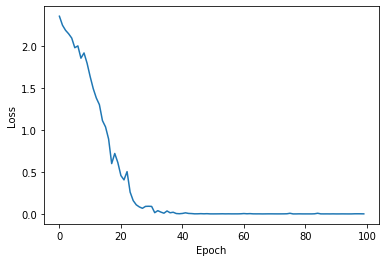

In [9]:
# Create a new model, and train it on 10 samples only 

model2 = build_model()

hist = model2.fit(xtrain[indices[0,:]], ytrain[indices[0,:]],
                  batch_size=128,
                  epochs=100,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
print()

score = model2.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

# Minimalistic training with random first layers

[False, False, False, False, False, False, False, True]

 2.366 2.321 2.314 2.299 2.324 2.310 2.297 2.327 2.260 2.297
 2.344 2.326 2.314 2.291 2.330 2.302 2.310 2.336 2.342 2.358
 2.338 2.328 2.360 2.286 2.325 2.336 2.282 2.370 2.323 2.308
 2.254 2.321 2.338 2.291 2.293 2.312 2.263 2.332 2.295 2.300
 2.280 2.260 2.335 2.330 2.262 2.254 2.282 2.303 2.344 2.318
 2.319 2.279 2.269 2.296 2.289 2.303 2.244 2.315 2.239 2.270
 2.279 2.279 2.317 2.289 2.289 2.316 2.243 2.230 2.280 2.269
 2.269 2.299 2.294 2.312 2.269 2.202 2.272 2.262 2.194 2.305
 2.255 2.255 2.329 2.235 2.258 2.288 2.279 2.268 2.293 2.265
 2.268 2.264 2.282 2.292 2.271 2.249 2.243 2.248 2.228 2.277
Test loss: 2.2850140266418455
Accuracy: 0.1479
Percent error: 85.21%


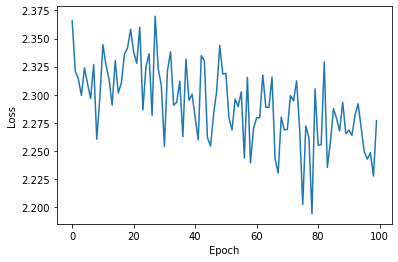

In [10]:
# Reset the model, and train it on 10 samples only 

model2 = build_model()

# Freeze all layers but last
for layer in model2.layers[:-1]:
    layer.trainable = False
    
print([l.trainable for l in model2.layers])

# Recompile the model
model2.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

hist = model2.fit(xtrain[indices[0,:]], ytrain[indices[0,:]],
                  batch_size=128,
                  epochs=100,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
print()

score = model2.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

# Freeze layers and retrain

Refs:
* https://keras.io/guides/transfer_learning/

In [11]:
# Save weights
# model.save('weights_full')

In [12]:
# Reset the last (softmax) layer:
model3 = tf.keras.Sequential()

for layer in model.layers[:-1]: # Copy from model1
    model3.add(layer)
    
for layer in model3.layers:
    layer.trainable = False
    
model3.add(tf.keras.layers.Dense(C.nclasses, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

print([l.trainable for l in model3.layers])

[False, False, False, False, False, False, False, True]


In [13]:
# Untrained, so should perform at chance level (10%)
score = model3.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')

Test loss: 10.843141172790528
Accuracy: 0.0565
Percent error: 94.35%



 14.317 11.884 12.449 12.213 12.836 11.297 12.051 11.110 11.383 1.752
 11.141 11.214 8.634 1.088 9.294 9.371 9.845 9.796 9.487 9.481
 9.181 8.976 7.766 8.481 7.751 8.479 6.184 7.168 5.681 6.855
 5.684 6.062 5.721 7.698 5.813 5.932 6.106 4.759 5.846 5.251
 5.504 4.855 4.642 4.241 4.115 4.214 3.133 4.002 4.360 4.395
 3.527 2.839 3.819 3.208 3.040 3.063 3.476 2.912 2.441 4.062
 3.892 2.828 1.425 3.010 2.874 2.445 2.792 2.066 2.740 2.517
 2.603 1.351 2.045 2.074 1.571 2.065 2.121 1.341 1.373 1.961
 1.537 .943 1.681 1.902 1.939 .959 .946 1.491 .903 .676
 1.025 .304 .635 1.139 .367 .937 .387 .613 1.151 .241
 .531 .559 .544 .936 .374 .338 .288 .467 .643 .708
 .190 .475 .204 .071 .079 .107 .489 .154 .035 .294
 .056 .438 .050 .091 .106 .311 .313 .024 .085 .130
 .274 .070 .138 .064 .065 .008 .055 .090 .081 .079
 .121 .081 .066 .086 .033 .064 .055 .038 .028 .084
 .047 .027 .101 .034 .041 .009 .047 .121 .268 .015
 .046 .053 .111 .020 .033 .027 .040 .100 .030 .051
 .055 .014 .055 .008 .036 .016 .1

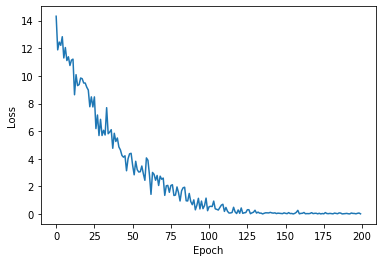

In [14]:
# Retrain last layer on one set of numbers only

hist = model3.fit(xtrain[indices[0,:]], ytrain[indices[0,:]],
                  batch_size=128,
                  epochs=200,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
print()

print()
score = model3.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}%')